# Lambda School Data Science - Making Data-backed Assertions

This is, for many, the main point of data science - to create and support reasoned arguments based on evidence. It's not a topic to master in a day, but it is worth some focused time thinking about and structuring your approach to it.

## Lecture - generating a confounding variable

The prewatch material told a story about a hypothetical health condition where both the drug usage and overall health outcome were related to gender - thus making gender a confounding variable, obfuscating the possible relationship between the drug and the outcome.

Let's use Python to generate data that actually behaves in this fashion!

In [0]:
import random
dir(random)  # Reminding ourselves what we can do here

['BPF',
 'LOG4',
 'NV_MAGICCONST',
 'RECIP_BPF',
 'Random',
 'SG_MAGICCONST',
 'SystemRandom',
 'TWOPI',
 '_BuiltinMethodType',
 '_MethodType',
 '_Sequence',
 '_Set',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_acos',
 '_bisect',
 '_ceil',
 '_cos',
 '_e',
 '_exp',
 '_inst',
 '_itertools',
 '_log',
 '_pi',
 '_random',
 '_sha512',
 '_sin',
 '_sqrt',
 '_test',
 '_test_generator',
 '_urandom',
 '_warn',
 'betavariate',
 'choice',
 'choices',
 'expovariate',
 'gammavariate',
 'gauss',
 'getrandbits',
 'getstate',
 'lognormvariate',
 'normalvariate',
 'paretovariate',
 'randint',
 'random',
 'randrange',
 'sample',
 'seed',
 'setstate',
 'shuffle',
 'triangular',
 'uniform',
 'vonmisesvariate',
 'weibullvariate']

In [0]:
import random
import numpy as np
import pandas as pd

df = pd.DataFrame({'a': np.arange(100000)})

In [0]:
%%timeit
df['b'] = df['a'].apply(lambda x: np.sin(x**2))

1 loop, best of 3: 186 ms per loop


In [0]:
%%timeit
df['b'] = np.sin(df['a']**2)

The slowest run took 6.07 times longer than the fastest. This could mean that an intermediate result is being cached.
100 loops, best of 3: 5.86 ms per loop


In [0]:
# Let's think of another scenario:
# We work for a company that sells accessories for mobile phones.
# They have an ecommerce site, and we are supposed to analyze logs
# to determine what sort of usage is related to purchases, and thus guide
# website development to encourage higher conversion.

# The hypothesis - users who spend longer on the site tend
# to spend more. Seems reasonable, no?

# But there's a confounding variable! If they're on a phone, they:
# a) Spend less time on the site, but
# b) Are more likely to be interested in the actual products!

# Let's use namedtuple to represent our data

from collections import namedtuple
# purchased and mobile are bools, time_on_site in seconds
User = namedtuple('User', ['purchased','time_on_site', 'mobile'])

example_user = User(False, 12, False)
print(example_user)

User(purchased=False, time_on_site=12, mobile=False)


In [0]:
# And now let's generate 1000 example users
# 750 mobile, 250 not (i.e. desktop)
# A desktop user has a base conversion likelihood of 10%
# And it goes up by 1% for each 15 seconds they spend on the site
# And they spend anywhere from 10 seconds to 10 minutes on the site (uniform)
# Mobile users spend on average half as much time on the site as desktop
# But have three times as much base likelihood of buying something

users = []

for _ in range(250):
  # Desktop users
  time_on_site = np.random.normal(420, 100)
  purchased = random.random() < 0.1 + (time_on_site / 1500)
  users.append(User(purchased, time_on_site, False))
  
for _ in range(750):
  # Mobile users
  time_on_site = np.random.normal(200, 90)
  purchased = random.random() < 0.3 + (time_on_site / 1500)
  users.append(User(purchased, time_on_site, True))
  
random.shuffle(users)
print(users[:10])

[User(purchased=False, time_on_site=203.812460680267, mobile=True), User(purchased=True, time_on_site=304.5983585922901, mobile=True), User(purchased=True, time_on_site=403.3633215367553, mobile=False), User(purchased=True, time_on_site=551.4505553326815, mobile=False), User(purchased=False, time_on_site=372.259352908308, mobile=False), User(purchased=True, time_on_site=464.9066951574843, mobile=False), User(purchased=False, time_on_site=326.22054053211974, mobile=False), User(purchased=True, time_on_site=653.550671376443, mobile=False), User(purchased=True, time_on_site=156.1655675086613, mobile=True), User(purchased=True, time_on_site=340.0431045334034, mobile=True)]


In [0]:
# Let's put this in a dataframe so we can look at it more easily
import pandas as pd
user_data = pd.DataFrame(users)
user_data.head()

,purchased,time_on_site,mobile
0,False,203.812461,True
1,True,304.598359,True
2,True,403.363322,False
3,True,551.450555,False
4,False,372.259353,False


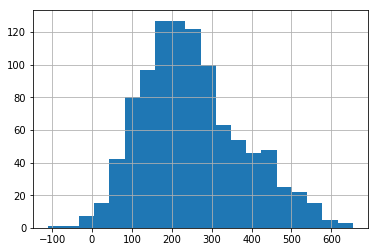

In [0]:
user_data['time_on_site'].hist(bins=20)

In [0]:
# Let's use crosstabulation to try to see what's going on
pd.crosstab(user_data['purchased'], user_data['time_on_site'])

time_on_site,-109.03542389754205,-37.46082284578284,-16.855593570841762,-13.719708054617826,-12.41936646812448,0.5665709345905157,2.823548234580926,3.03501299468266,4.645835092665067,5.435871543242513,...,574.6848609423313,575.8341554409866,580.4218354226338,585.1943320552093,586.1633624744601,596.694756864094,607.9934946877481,630.2967708271916,638.5381732673642,653.550671376443
purchased,,,,,,,,,,,,,,,,,,,,,
False,1,1,1,1,1,1,0,1,1,1,...,0,1,1,1,1,1,0,0,1,0
True,0,0,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,1,1,0,1


In [0]:
user_data.loc[user_data['time_on_site'] < 0, 'time_on_site'] = np.NaN

In [0]:
user_data.isnull()

,purchased,time_on_site,mobile
0,False,False,False
1,False,False,False
2,False,False,False
3,False,False,False
4,False,False,False
5,False,False,False
6,False,False,False
7,False,False,False
8,False,False,False
9,False,False,False


In [0]:
# OK, that's not quite what we want
# Time is continuous! We need to put it in discrete buckets
# Pandas calls these bins, and pandas.cut helps make them

time_bins = pd.cut(user_data['time_on_site'], bins=5)  # 5 equal-sized bins
pd.crosstab(time_bins, user_data['purchased'])

purchased,False,True
time_on_site,,
"(-0.0864, 131.163]",113,53
"(131.163, 261.76]",235,186
"(261.76, 392.357]",146,104
"(392.357, 522.954]",66,60
"(522.954, 653.551]",17,15


In [0]:
# We can make this a bit clearer by normalizing (getting %)
pd.crosstab(time_bins, user_data['purchased'], normalize='columns')

purchased,False,True
time_on_site,,
"(-0.0864, 131.163]",0.195841,0.126794
"(131.163, 261.76]",0.407279,0.444976
"(261.76, 392.357]",0.253033,0.248804
"(392.357, 522.954]",0.114385,0.143541
"(522.954, 653.551]",0.029463,0.035885


In [0]:
# That seems counter to our hypothesis
# More time on the site can actually have fewer purchases

# But we know why, since we generated the data!
# Let's look at mobile and purchased
pd.crosstab(user_data['purchased'], user_data['mobile'], normalize='columns')

mobile,False,True
purchased,,
False,0.584,0.581333
True,0.416,0.418667


In [0]:
# Yep, mobile users are more likely to buy things
# But we're still not seeing the *whole* story until we look at all 3 at once

# Live/stretch goal - how can we do that?
pd.crosstab(time_bins, [user_data['mobile'], user_data['purchased']], normalize='all')

mobile                 False               True           
purchased              False     True      False     True 
time_on_site                                              
(-0.0864, 131.163]  0.001005  0.000000  0.112563  0.053266
(131.163, 261.76]   0.009045  0.005025  0.227136  0.181910
(261.76, 392.357]   0.057286  0.030151  0.089447  0.074372
(392.357, 522.954]  0.062312  0.054271  0.004020  0.006030
(522.954, 653.551]  0.017085  0.015075  0.000000  0.000000

## Assignment - what's going on here?

Consider the data in `persons.csv` (already prepared for you, in the repo for the week). It has four columns - a unique id, followed by age (in years), weight (in lbs), and exercise time (in minutes/week) of 1200 (hypothetical) people.

Try to figure out which variables are possibly related to each other, and which may be confounding relationships.

In [0]:
# TODO - your code here
# Use what we did live in lecture as an example

# HINT - you can find the raw URL on GitHub and potentially use that
# to load the data with read_csv, or you can upload it yourself

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [0]:
persons_df = pd.read_csv('https://raw.githubusercontent.com/ElisabethShah/DS-Unit-1-Sprint-1-Dealing-With-Data/master/module3-databackedassertions/persons.csv', 
                        usecols = ['age', 'weight', 'exercise_time'])

In [0]:
persons_df.sample(5)

,age,weight,exercise_time
732,27,145,156
1194,64,122,184
331,49,216,2
724,26,167,189
1126,24,101,300


In [0]:
persons_df.dtypes

age              int64
weight           int64
exercise_time    int64
dtype: object

In [0]:
persons_df.describe()

,age,weight,exercise_time
count,1200.000000,1200.000000,1200.000000
mean,48.396667,153.540833,134.910833
std,18.166802,35.132182,85.548895
min,18.000000,100.000000,0.000000
25%,33.000000,125.000000,65.000000
50%,48.000000,149.000000,122.000000
75%,64.000000,180.250000,206.000000
max,80.000000,246.000000,300.000000


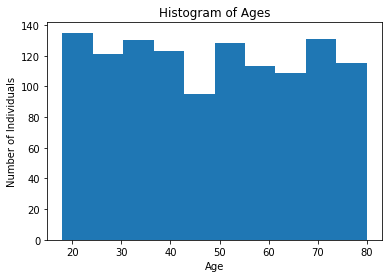

In [0]:
plt.hist(persons_df.age)
plt.title('Histogram of Ages')
plt.xlabel('Age')
plt.ylabel('Number of Individuals')
plt.show()

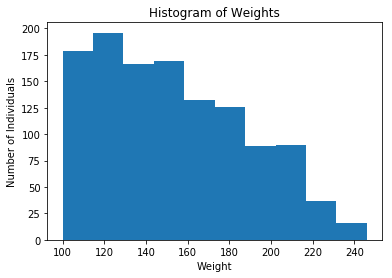

In [0]:
plt.hist(persons_df.weight)
plt.title('Histogram of Weights')
plt.xlabel('Weight')
plt.ylabel('Number of Individuals')
plt.show()

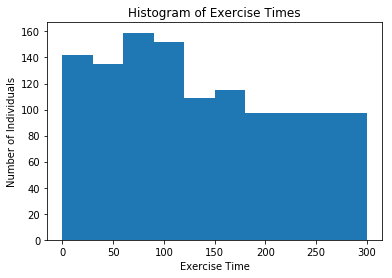

In [0]:
plt.hist(persons_df.exercise_time)
plt.title('Histogram of Exercise Times')
plt.xlabel('Exercise Time')
plt.ylabel('Number of Individuals')
plt.show()

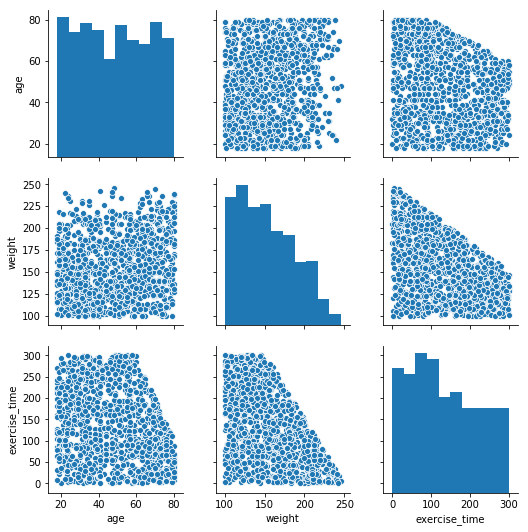

In [0]:
sns.pairplot(persons_df);

In [0]:
np.corrcoef(persons_df.age, persons_df.weight)

array([[1.        , 0.14416819],
       [0.14416819, 1.        ]])

In [0]:
np.corrcoef(persons_df.age, persons_df.exercise_time)

array([[ 1.        , -0.27381804],
       [-0.27381804,  1.        ]])

In [0]:
np.corrcoef(persons_df.exercise_time, persons_df.weight)

array([[ 1.        , -0.47802133],
       [-0.47802133,  1.        ]])

In [0]:
persons_df['age_bin'] = pd.cut(persons_df.age, bins = 6, include_lowest = True).astype(str)
persons_df['weight_bin'] = pd.cut(persons_df.weight, np.linspace(100, 250, num = 11), include_lowest = True).astype(str)
persons_df['exercise_bin'] = pd.cut(persons_df.exercise_time, np.linspace(0, 300, num = 7), include_lowest = True).astype(str)

In [0]:
persons_df['age_bin'].value_counts()

(28.333, 38.667]                217
(17.936999999999998, 28.333]    209
(38.667, 49.0]                  200
(69.667, 80.0]                  198
(59.333, 69.667]                192
(49.0, 59.333]                  184
Name: age_bin, dtype: int64

In [0]:
persons_df['weight_bin'].value_counts()

(115.0, 130.0]     196
(99.999, 115.0]    187
(130.0, 145.0]     182
(145.0, 160.0]     167
(160.0, 175.0]     133
(175.0, 190.0]     121
(190.0, 205.0]      97
(205.0, 220.0]      77
(220.0, 235.0]      27
(235.0, 250.0]      13
Name: weight_bin, dtype: int64

In [0]:
persons_df['exercise_bin'].value_counts()

(50.0, 100.0]     264
(-0.001, 50.0]    241
(100.0, 150.0]    194
(150.0, 200.0]    190
(250.0, 300.0]    156
(200.0, 250.0]    155
Name: exercise_bin, dtype: int64

In [0]:
persons_df.sample(5)

,age,weight,exercise_time,age_bin,weight_bin,exercise_bin
199,29,119,282,"(28.333, 38.667]","(115.0, 130.0]","(250.0, 300.0]"
1164,53,103,276,"(49.0, 59.333]","(99.999, 115.0]","(250.0, 300.0]"
41,80,186,87,"(69.667, 80.0]","(175.0, 190.0]","(50.0, 100.0]"
1116,63,144,1,"(59.333, 69.667]","(130.0, 145.0]","(-0.001, 50.0]"
1112,58,144,89,"(49.0, 59.333]","(130.0, 145.0]","(50.0, 100.0]"


In [0]:
persons_df.dtypes

age               int64
weight            int64
exercise_time     int64
age_bin          object
weight_bin       object
exercise_bin     object
dtype: object

In [0]:
persons_df.isnull().any()

age              False
weight           False
exercise_time    False
age_bin          False
weight_bin       False
exercise_bin     False
dtype: bool

In [0]:
mean_weight_ct = pd.crosstab(persons_df.age_bin, persons_df.exercise_bin, values = persons_df.weight, aggfunc = np.mean)
mean_weight_ct

exercise_bin,"(-0.001, 50.0]","(100.0, 150.0]","(150.0, 200.0]","(200.0, 250.0]","(250.0, 300.0]","(50.0, 100.0]"
age_bin,,,,,,
"(17.936999999999998, 28.333]",180.310345,151.393939,144.911111,139.128205,122.035714,165.885714
"(28.333, 38.667]",174.895833,153.344828,140.976190,131.058824,129.343750,150.531250
"(38.667, 49.0]",183.222222,158.120000,142.807692,134.138889,127.695652,166.375000
"(49.0, 59.333]",166.538462,158.655172,148.586207,137.375000,126.956522,175.400000
"(59.333, 69.667]",184.772727,156.454545,145.250000,135.636364,135.750000,165.735849
"(69.667, 80.0]",169.686567,154.155556,136.583333,NaN,NaN,166.094595


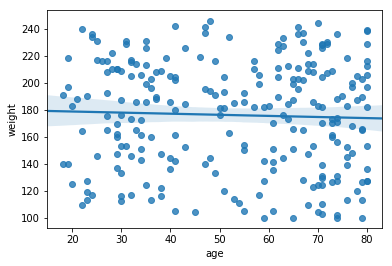

In [0]:
sns.regplot(persons_df[persons_df.exercise_bin == '(-0.001, 50.0]'].age, persons_df[persons_df.exercise_bin == '(-0.001, 50.0]'].weight);

In [0]:
np.corrcoef(persons_df[persons_df.exercise_bin == '(-0.001, 50.0]'].age, persons_df[persons_df.exercise_bin == '(-0.001, 50.0]'].weight)

array([[ 1.        , -0.03889818],
       [-0.03889818,  1.        ]])

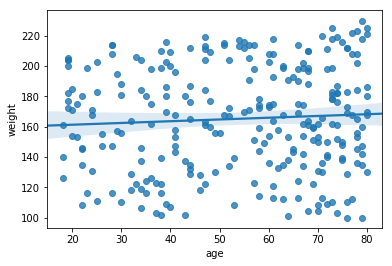

In [0]:
sns.regplot(persons_df[persons_df.exercise_bin == '(50.0, 100.0]'].age, persons_df[persons_df.exercise_bin == '(50.0, 100.0]'].weight);

In [0]:
np.corrcoef(persons_df[persons_df.exercise_bin == '(50.0, 100.0]'].age, persons_df[persons_df.exercise_bin == '(50.0, 100.0]'].weight)

array([[1.        , 0.06289446],
       [0.06289446, 1.        ]])

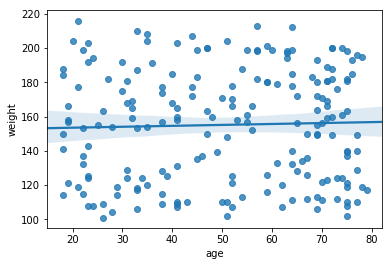

In [0]:
sns.regplot(persons_df[persons_df.exercise_bin == '(100.0, 150.0]'].age, persons_df[persons_df.exercise_bin == '(100.0, 150.0]'].weight);

In [0]:
np.corrcoef(persons_df[persons_df.exercise_bin == '(100.0, 150.0]'].age, persons_df[persons_df.exercise_bin == '(100.0, 150.0]'].weight)

array([[1.        , 0.03181193],
       [0.03181193, 1.        ]])

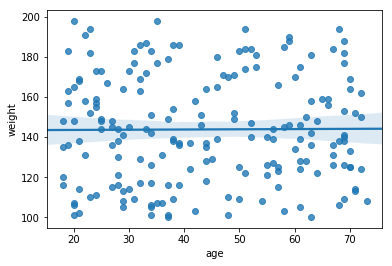

In [0]:
sns.regplot(persons_df[persons_df.exercise_bin == '(150.0, 200.0]'].age, persons_df[persons_df.exercise_bin == '(150.0, 200.0]'].weight);

In [0]:
np.corrcoef(persons_df[persons_df.exercise_bin == '(150.0, 200.0]'].age, persons_df[persons_df.exercise_bin == '(150.0, 200.0]'].weight)

array([[1.        , 0.00689758],
       [0.00689758, 1.        ]])

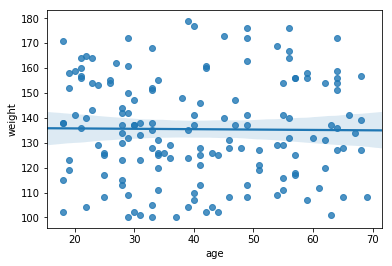

In [0]:
sns.regplot(persons_df[persons_df.exercise_bin == '(200.0, 250.0]'].age, persons_df[persons_df.exercise_bin == '(200.0, 250.0]'].weight);

In [0]:
np.corrcoef(persons_df[persons_df.exercise_bin == '(200.0, 250.0]'].age, persons_df[persons_df.exercise_bin == '(200.0, 250.0]'].weight)

array([[ 1.        , -0.01102847],
       [-0.01102847,  1.        ]])

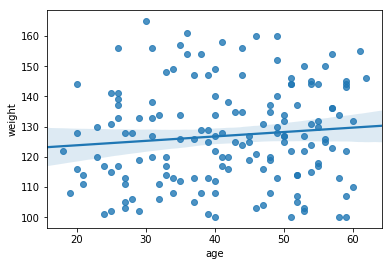

In [0]:
sns.regplot(persons_df[persons_df.exercise_bin == '(250.0, 300.0]'].age, persons_df[persons_df.exercise_bin == '(250.0, 300.0]'].weight);

In [0]:
np.corrcoef(persons_df[persons_df.exercise_bin == '(250.0, 300.0]'].age, persons_df[persons_df.exercise_bin == '(250.0, 300.0]'].weight)

array([[1.        , 0.10494501],
       [0.10494501, 1.        ]])

### Assignment questions

After you've worked on some code, answer the following questions in this text block:

1.  What are the variable types in the data?


> **They are all 64-bit integers.**


2.  What are the relationships between the variables?


> **Age and weight show a very weak positive correlation. Age and exercise time show a weak negative correlation, and there is a moderate negative correlation between exercise time and weight.**


3.  Which relationships are "real", and which spurious?
The correlation between age and weight, already weak, essentially disappears when exercise time is held constant; it appears largely spurious, based on this data. The correlations between age and exercise time and between exercise time and weight appear more solid.


## Stretch goals and resources

Following are *optional* things for you to take a look at. Focus on the above assignment first, and make sure to commit and push your changes to GitHub.

- [Spurious Correlations](http://tylervigen.com/spurious-correlations)
- [NIH on controlling for confounding variables](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4017459/)

Stretch goals:

- Produce your own plot inspired by the Spurious Correlation visualizations (and consider writing a blog post about it - both the content and how you made it)
- Pick one of the techniques that NIH highlights for confounding variables - we'll be going into many of them later, but see if you can find which Python modules may help (hint - check scikit-learn)